In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import argparse
import numpy as np
import torch
import cPickle as cp
import sys, os
sys.path.append("../../utils")
sys.path.append("../")

from data_loader import load_census_data, load_census_data_part
from plot_utils import get_colors
import rff
from rff import GaussianKernel, RFF
from kernel_regressor import Quantizer, KernelRidgeRegression
from bit_assignment import binary_search_bits_assignment
from pca_rff import PCA_RFF
import cPickle as cp
from misc_utils import Args

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
data_path = "../../../data/census/"

In [51]:
X_train, X_test, Y_train, Y_test = load_census_data(data_path)
n_input_feat = X_train.shape[1]
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=True, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)

In [52]:
n_fp_feat_budget = 1024
F_norm_fp_rff_sqr = 217285107.943

In [ ]:
# get a low precision PCA RFF
kernel = GaussianKernel(sigma=args.sigma)
kernel = PCA_RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed, mu=10.0)
kernel.setup(X_train, n_fp_feat_budget=n_fp_feat_budget, bits_upperbound=32)

In [ ]:
rff = kernel.get_cos_feat(X_train)
kernel_baseline = torch.mm(rff, torch.transpose(rff, 0, 1) )

In [ ]:
with open("./tmp/rotation_mat_U.npy", "w") as f:
    np.save(f, kernel.U.cpu().numpy() )
with open("./tmp/rotation_mat_U.npy", "r") as f:
    U = np.load(f)
with open("./tmp/original_rff.npy", "w") as f:
    np.save(f, rff.cpu().numpy() )
with open("./tmp/original_rff.npy", "r") as f:
    rff = np.load(f)
with open("./tmp/kernel_baseline.npy", "w") as f:
    np.save(f, kernel_baseline)

###  Verification row of ZU is a rotated feature representation

In [ ]:
# print np.std(np.dot(rff, U), axis=0)
# print kernel.std
print type(U)

In [ ]:
class Quantizer(object):
  def __init__(self, nbit, min_val, max_val, scale=None, rand_seed=1):
    self.nbit = nbit
    self.min_val = min_val
    self.max_val = max_val
    if scale == None:
      self.scale = (max_val - min_val) / float(2**self.nbit - 1)
    self.rand_seed = rand_seed

  def quantize_random(self, value, verbose=True):
#     value = torch.clamp(value, self.min_val, self.max_val)
    floor_val = self.min_val + torch.floor( (value - self.min_val) / self.scale) * self.scale
    ceil_val = self.min_val + torch.ceil( (value - self.min_val) / self.scale) * self.scale
    # print("test in the middle ", torch.min(floor_val), torch.max(ceil_val), self.min_val, self.max_val)
    # exit(0)
    floor_prob = (ceil_val - value) / self.scale
    ceil_prob = (value - floor_val) / self.scale
    # sanity check
    # np.testing.assert_array_almost_equal(floor_prob.cpu().numpy(), 
    #   1 - ceil_prob.cpu().numpy(), decimal=6)
    # if verbose:
    #   print("quantizer using random seed", self.rand_seed)
    np.random.seed(self.rand_seed)
    sample = torch.DoubleTensor(np.random.uniform(size=list(value.size() ) ) )
    # quant_val = floor_val * (sample < floor_prob).float() \
    #   + ceil_val * (sample >= floor_prob).float()
    quant_val = floor_val * (sample < floor_prob).double() \
      + ceil_val * (sample >= floor_prob).double()
    return quant_val

  def quantize(self, value, verbose=True):
    # TODO update if we have other quantization schemes
    return self.quantize_random(value, verbose)

### spectrum generation on the counterpart on server

In [ ]:
def plot_with_percentile(upper, lower):
    spectrum_dict = {}
    plt.figure()
#     for n_top_comp in [0, ]:
    for n_top_comp in [0, 10, 100, 1000]:
        print "percent ", n_top_comp / float(rff.shape[0] )
        rff_offset = np.mean(rff, axis=0)
        rff_center = rff - rff_offset
        main_comp = np.dot(rff_center, U[:, 0:n_top_comp])
        residual = rff_center - np.dot(main_comp, U[:, 0:n_top_comp].T)
#         dy_range = np.max(residual, axis=0) - np.min(residual, axis=0)
#         dy_range_1 = np.percentile(residual, q=99, axis=0) - np.percentile(residual, q=1, axis=0)
#         dy_range_10 = np.percentile(residual, q=90, axis=0) - np.percentile(residual, q=10, axis=0)

        kernel_approx_error_list = []
        for nbit in [1, 2, 4, 8, 16, 32]:
            min_val = np.percentile(residual, q=lower, axis=0)
            max_val = np.percentile(residual, q=upper, axis=0)
            residual_clamp = np.clip(residual, min_val, max_val)
#             print np.max(residual_clamp, axis=0), max_val
#             print np.min(residual_clamp, axis=0), min_val
            min_val = np.tile(np.percentile(residual, q=lower, axis=0).reshape(1, min_val.size), (rff.shape[0], 1) )
            max_val = np.tile(np.percentile(residual, q=upper, axis=0).reshape(1, max_val.size), (rff.shape[0], 1) )
            quantizer = Quantizer(nbit, torch.DoubleTensor(min_val), 
                                  torch.DoubleTensor(max_val), rand_seed=1)
            quant_residual = quantizer.quantize(torch.DoubleTensor(residual_clamp), verbose=False).cpu().numpy()
    #         quant_residual = residual
            recover_rff = np.dot(main_comp, U[:, 0:n_top_comp].T)
            recover_rff += quant_residual
            recover_rff += rff_offset        
            recover_kernel_mat = np.dot(recover_rff, recover_rff.T)
            kernel_approx_error = np.sum( (kernel_baseline.cpu().numpy() - recover_kernel_mat)**2)
            kernel_approx_error_list.append(kernel_approx_error)
            print "done bits ", nbit
#             _, S, _ = np.linalg.svd(recover_kernel_mat)
#             spectrum_dict["upper_" + str(upper) + "_n_top_" + str(n_top_comp) + "_nbit_" + str(nbit) ] = S
        plt.plot(np.sqrt(np.array(kernel_approx_error_list) / F_norm_fp_rff_sqr), label="n top comp " + str(n_top_comp) )
    #         print kernel_baseline.cpu().numpy().ravel()[:20]
    #         print recover_kernel_mat.ravel()[:20]
    #         raw_input()
        print "n top comp ", n_top_comp, kernel_approx_error_list
    plt.grid()
    plt.legend()
    ax = plt.subplot(111)
    ax.set_yscale('log')
    plt.show()
    return spectrum_dict

In [11]:
# val_10 = [2445749.1793917837, 90983.05670742986, 3575.4054838067823, 11.884725505977123, 0.00018462084635229321, 4.2366721601303593e-14]
# val_100 = [755943.12067424238, 39491.256157772084, 1583.0134186175358, 5.3615856278197169, 8.2026551445892452e-05, 1.8832408799369611e-14]
# val_1000 = [32.974419743918432, 3.1134650391946259, 0.10061072304108232, 0.00034411362396194939, 5.2218140425769637e-09, 1.2198138807298336e-18]

In [ ]:
# plt.figure()
# plt.semilogy(np.sqrt(np.array(val_10) / 217285107.943), label="10")
# plt.semilogy(np.sqrt(np.array(val_100) / 217285107.943), label="100")
# plt.semilogy(np.sqrt(np.array(val_1000) / 217285107.943), label="1000")
# plt.grid()
# plt.show()

In [ ]:
spectrum_dict = plot_with_percentile(upper=100, lower=0)
# with open("./tmp/spectrums_upper_" + str(100) + ".npy", "w") as f:
#     cp.dump(spectrum_dict, f)

In [ ]:
spectrum_dict = plot_with_percentile(upper=99, lower=1)
# with open("./tmp/spectrums_upper_" + str(99) + ".npy", "w") as f:
#     cp.dump(spectrum_dict, f)

In [ ]:
spectrum_dict = plot_with_percentile(upper=90, lower=10)
# with open("./tmp/spectrums_upper_" + str(90) + ".npy", "w") as f:
#     cp.dump(spectrum_dict, f)

percent  0.0


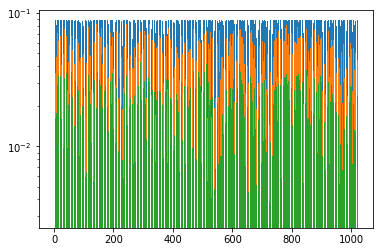

percent  0.000610985519643


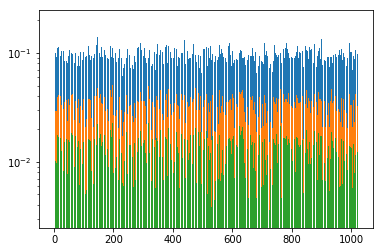

percent  0.00610985519643


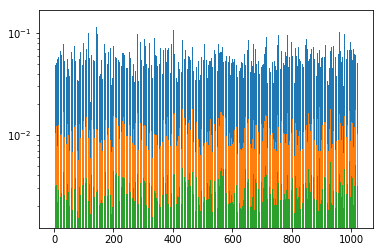

percent  0.0610985519643


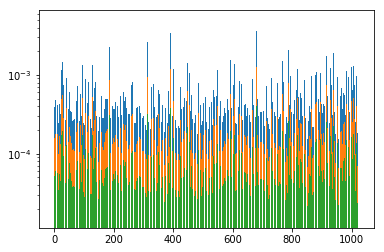

percent  0.610985519643


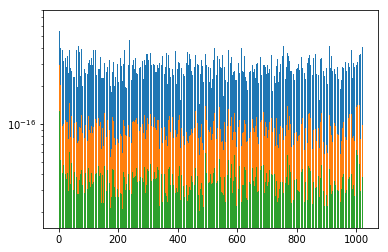

In [48]:
for n_top_comp in [0, 10, 100, 1000, 10000]:
    plt.figure()
    print "percent ", n_top_comp / float(rff.shape[0] )
    rff_offset = np.mean(rff, axis=0)
    rff_center = rff - rff_offset
    main_comp = np.dot(rff_center, U[:, 0:n_top_comp])
    residual = rff_center - np.dot(main_comp, U[:, 0:n_top_comp].T)
    dy_range = np.max(residual, axis=0) - np.min(residual, axis=0)
    dy_range_1 = np.percentile(residual, q=99, axis=0) - np.percentile(residual, q=1, axis=0)
    dy_range_10 = np.percentile(residual, q=90, axis=0) - np.percentile(residual, q=10, axis=0)
    plt.bar(np.arange(dy_range.size), dy_range)
    plt.bar(np.arange(dy_range.size), dy_range_1)
    plt.bar(np.arange(dy_range.size), dy_range_10)
    ax = plt.subplot(111)
    ax.set_yscale("log")
    plt.show()    

### plot spectrums

In [27]:
with open("./tmp/spectrums_upper_" + str(100) + ".npy", "r") as f:
    spectrums_upper_100 = cp.load(f)
with open("./tmp/spectrums_upper_" + str(99) + ".npy", "r") as f:
    spectrums_upper_99 = cp.load(f)
with open("./tmp/spectrums_upper_" + str(90) + ".npy", "r") as f:
    spectrums_upper_90 = cp.load(f)
with open("./exact_kernel_spectrum.npy", "r") as f:
    spectrums_exact = np.load(f)
with open("./spectrum_rff_pca_sqr_with_l2_n_base_feat_1024.pkl", "r") as f:
    spectrums = cp.load(f)
spectrums_fp = spectrums["fp_rff_error"]
with open("./spectrum_rff_pca_sqr_with_l2_n_base_feat_8192.pkl", "r") as f:
    spectrums_fix_bit = cp.load(f)
# np.savetxt("./fp_rff_kernel_spectrum_1024.txt", spectrums["fp_rff_error"], delimiter=",")

In [28]:
print spectrums_upper_100.keys()

['upper_100_n_top_10_nbit_4', 'upper_100_n_top_10_nbit_2', 'upper_100_n_top_10_nbit_1', 'upper_100_n_top_10_nbit_8', 'upper_100_n_top_100_nbit_8', 'upper_100_n_top_100_nbit_4', 'upper_100_n_top_100_nbit_2', 'upper_100_n_top_100_nbit_1', 'upper_100_n_top_1000_nbit_8', 'upper_100_n_top_0_nbit_16', 'upper_100_n_top_1000_nbit_4', 'upper_100_n_top_1000_nbit_1', 'upper_100_n_top_1000_nbit_2', 'upper_100_n_top_10_nbit_16', 'upper_100_n_top_10_nbit_32', 'upper_100_n_top_1000_nbit_16', 'upper_100_n_top_0_nbit_2', 'upper_100_n_top_0_nbit_1', 'upper_100_n_top_0_nbit_4', 'upper_100_n_top_0_nbit_8', 'upper_100_n_top_100_nbit_16', 'upper_100_n_top_1000_nbit_32', 'upper_100_n_top_0_nbit_32', 'upper_100_n_top_100_nbit_32']


### plot upper 100 spectrum

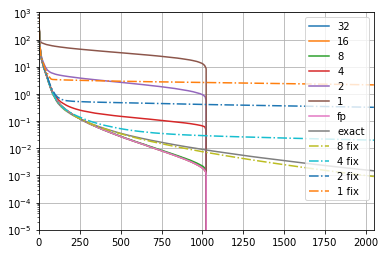

In [40]:
plt.figure()
plt.semilogy(spectrums_upper_100["upper_100_n_top_10_nbit_32"], label="32")
plt.semilogy(spectrums_upper_100["upper_100_n_top_10_nbit_16"], label="16")
plt.semilogy(spectrums_upper_100["upper_100_n_top_10_nbit_8"], label="8")
plt.semilogy(spectrums_upper_100["upper_100_n_top_10_nbit_4"], label="4")
plt.semilogy(spectrums_upper_100["upper_100_n_top_10_nbit_2"], label="2")
plt.semilogy(spectrums_upper_100["upper_100_n_top_10_nbit_1"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

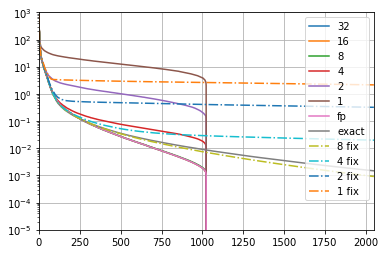

In [41]:
plt.figure()
plt.semilogy(spectrums_upper_100["upper_100_n_top_100_nbit_32"], label="32")
plt.semilogy(spectrums_upper_100["upper_100_n_top_100_nbit_16"], label="16")
plt.semilogy(spectrums_upper_100["upper_100_n_top_100_nbit_8"], label="8")
plt.semilogy(spectrums_upper_100["upper_100_n_top_100_nbit_4"], label="4")
plt.semilogy(spectrums_upper_100["upper_100_n_top_100_nbit_2"], label="2")
plt.semilogy(spectrums_upper_100["upper_100_n_top_100_nbit_1"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

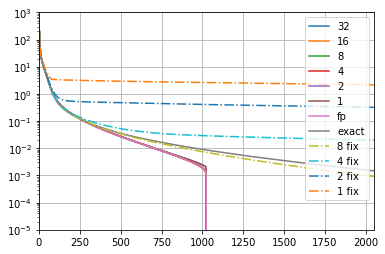

In [42]:
plt.figure()
plt.semilogy(spectrums_upper_100["upper_100_n_top_1000_nbit_32"], label="32")
plt.semilogy(spectrums_upper_100["upper_100_n_top_1000_nbit_16"], label="16")
plt.semilogy(spectrums_upper_100["upper_100_n_top_1000_nbit_8"], label="8")
plt.semilogy(spectrums_upper_100["upper_100_n_top_1000_nbit_4"], label="4")
plt.semilogy(spectrums_upper_100["upper_100_n_top_1000_nbit_2"], label="2")
plt.semilogy(spectrums_upper_100["upper_100_n_top_1000_nbit_2"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

### plot upper 99

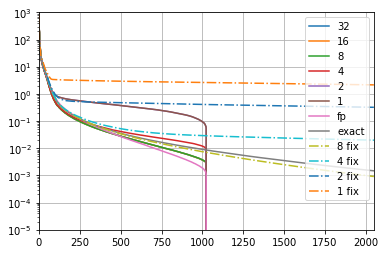

In [43]:
plt.figure()
plt.semilogy(spectrums_upper_99["upper_99_n_top_10_nbit_32"], label="32")
plt.semilogy(spectrums_upper_99["upper_99_n_top_10_nbit_16"], label="16")
plt.semilogy(spectrums_upper_99["upper_99_n_top_10_nbit_8"], label="8")
plt.semilogy(spectrums_upper_99["upper_99_n_top_10_nbit_4"], label="4")
plt.semilogy(spectrums_upper_99["upper_99_n_top_10_nbit_2"], label="2")
plt.semilogy(spectrums_upper_99["upper_99_n_top_10_nbit_2"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

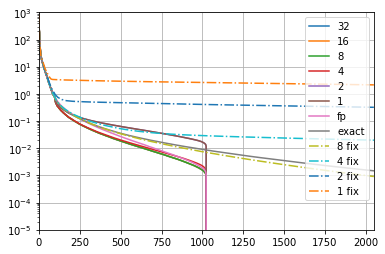

In [44]:
plt.figure()
plt.semilogy(spectrums_upper_99["upper_99_n_top_100_nbit_32"], label="32")
plt.semilogy(spectrums_upper_99["upper_99_n_top_100_nbit_16"], label="16")
plt.semilogy(spectrums_upper_99["upper_99_n_top_100_nbit_8"], label="8")
plt.semilogy(spectrums_upper_99["upper_99_n_top_100_nbit_4"], label="4")
plt.semilogy(spectrums_upper_99["upper_99_n_top_100_nbit_2"], label="2")
plt.semilogy(spectrums_upper_99["upper_99_n_top_100_nbit_2"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

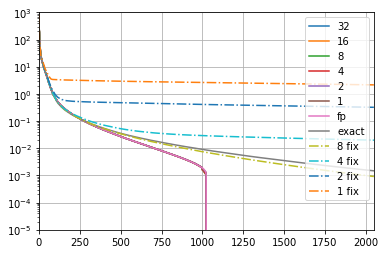

In [45]:
plt.figure()
plt.semilogy(spectrums_upper_99["upper_99_n_top_1000_nbit_32"], label="32")
plt.semilogy(spectrums_upper_99["upper_99_n_top_1000_nbit_16"], label="16")
plt.semilogy(spectrums_upper_99["upper_99_n_top_1000_nbit_8"], label="8")
plt.semilogy(spectrums_upper_99["upper_99_n_top_1000_nbit_4"], label="4")
plt.semilogy(spectrums_upper_99["upper_99_n_top_1000_nbit_2"], label="2")
plt.semilogy(spectrums_upper_99["upper_99_n_top_1000_nbit_2"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

### plot upper 90

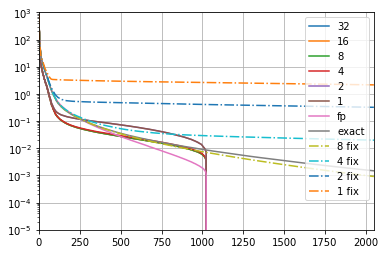

In [46]:
plt.figure()
plt.semilogy(spectrums_upper_90["upper_90_n_top_10_nbit_32"], label="32")
plt.semilogy(spectrums_upper_90["upper_90_n_top_10_nbit_16"], label="16")
plt.semilogy(spectrums_upper_90["upper_90_n_top_10_nbit_8"], label="8")
plt.semilogy(spectrums_upper_90["upper_90_n_top_10_nbit_4"], label="4")
plt.semilogy(spectrums_upper_90["upper_90_n_top_10_nbit_2"], label="2")
plt.semilogy(spectrums_upper_90["upper_90_n_top_10_nbit_2"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

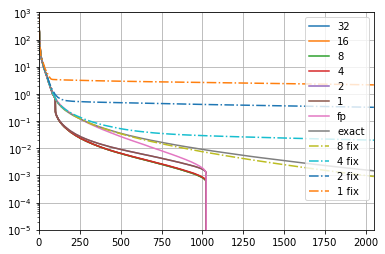

In [47]:
plt.figure()
plt.semilogy(spectrums_upper_90["upper_90_n_top_100_nbit_32"], label="32")
plt.semilogy(spectrums_upper_90["upper_90_n_top_100_nbit_16"], label="16")
plt.semilogy(spectrums_upper_90["upper_90_n_top_100_nbit_8"], label="8")
plt.semilogy(spectrums_upper_90["upper_90_n_top_100_nbit_4"], label="4")
plt.semilogy(spectrums_upper_90["upper_90_n_top_100_nbit_2"], label="2")
plt.semilogy(spectrums_upper_90["upper_90_n_top_100_nbit_2"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

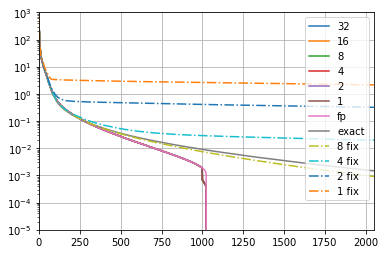

In [48]:
plt.figure()
plt.semilogy(spectrums_upper_90["upper_90_n_top_1000_nbit_32"], label="32")
plt.semilogy(spectrums_upper_90["upper_90_n_top_1000_nbit_16"], label="16")
plt.semilogy(spectrums_upper_90["upper_90_n_top_1000_nbit_8"], label="8")
plt.semilogy(spectrums_upper_90["upper_90_n_top_1000_nbit_4"], label="4")
plt.semilogy(spectrums_upper_90["upper_90_n_top_1000_nbit_2"], label="2")
plt.semilogy(spectrums_upper_90["upper_90_n_top_1000_nbit_2"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

In [41]:
n_top_comp = 0

<Container object of 1024 artists>

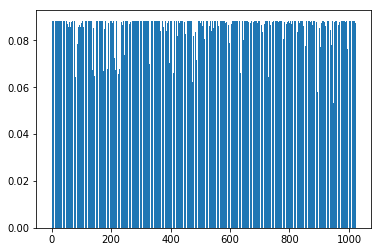

In [42]:
rff_center = rff - np.mean(rff, axis=0)
main_comp = np.dot(rff_center, U[:, 0:n_top_comp])
residual = rff_center - np.dot(main_comp, U[:, 0:n_top_comp].T)
dy_range = np.max(residual, axis=0) - np.min(residual, axis=0)
plt.bar(np.arange(dy_range.size), dy_range)

In [33]:
n_top_comp = 100

<Container object of 1024 artists>

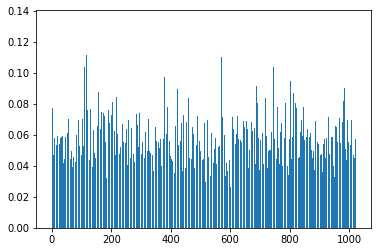

In [38]:
rff_center = rff - np.mean(rff, axis=0)
main_comp = np.dot(rff_center, U[:, 0:n_top_comp])
residual = rff_center - np.dot(main_comp, U[:, 0:n_top_comp].T)
dy_range = np.max(residual, axis=0) - np.min(residual, axis=0)
plt.bar(np.arange(dy_range.size), dy_range)

In [39]:
n_top_comp = 1000

<Container object of 1024 artists>

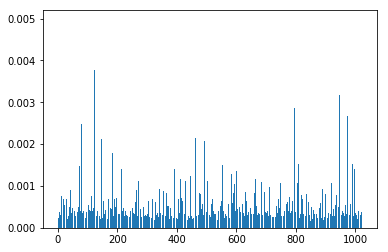

In [40]:
rff_center = rff - np.mean(rff, axis=0)
main_comp = np.dot(rff_center, U[:, 0:n_top_comp])
residual = rff_center - np.dot(main_comp, U[:, 0:n_top_comp].T)
dy_range = np.max(residual, axis=0) - np.min(residual, axis=0)
plt.bar(np.arange(dy_range.size), dy_range)